In [78]:
from sklearn.model_selection import train_test_split
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import svm, linear_model
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import metrics
import statsmodels.api as sm



def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


def calc_accuracy(y_true, y_predicted):
    TP_ = np.logical_and(y_predicted, y_true)
    FP_ = np.logical_and(y_predicted, np.logical_not(y_true))
    TN_ = np.logical_and(np.logical_not(y_predicted), np.logical_not(y_true))
    FN_ = np.logical_and(np.logical_not(y_predicted), y_true)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)
        
    accuracy = (TP + TN) / (TP + FP + TN + FN)    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    BER = 1 - 1/2 * (TPR + TNR)

    print("accuracy")
    print(accuracy)
    print("precision")
    print(precision)
    print("recall")
    print(recall)
    print("BER")
    print(BER)   

#function to one hot encode and bind to df
def features_to_encode_and_bind(features_to_encode, df):
    for feature in features_to_encode:
        dummies = pd.get_dummies(df[[feature]])
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([feature], axis=1)
    return df

#function to remove outliers
def features_to_removed(features_to_remove, dataframe):
    new_df = dataframe.copy()
    for column, value in features_to_remove:
        new_df = new_df[new_df[column] != value]
    return new_df

In [2]:
dataDir = "/Users/henryli/Desktop/CSE 258 Rec Sys/cse258/data/"
path = dataDir + "hotel_bookings_clean.csv"
df = pd.read_csv(path)
df['offset'] = 1
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'agent_is_null',
       'company_is_null', 'offset'],
      dtype='object')

In [3]:
month_one_hot_encode = pd.get_dummies(df.arrival_date_month)
month_one_hot_encode

,April,August,December,February,January,July,June,March,May,November,October,September
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
86935,0,1,0,0,0,0,0,0,0,0,0,0
86936,0,1,0,0,0,0,0,0,0,0,0,0
86937,0,1,0,0,0,0,0,0,0,0,0,0
86938,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:


new_df = df.loc[:, df.columns.intersection(['arrival_date_month','distribution_channel','children',"previous_cancellations",'booking_changes'])]
X = features_to_encode_and_bind(['arrival_date_month','distribution_channel'],new_df)
Y = df['is_canceled']

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

calc_accuracy(y_test, y_pred)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correct predictions
print("Precision:",metrics.precision_score(y_test, y_pred)) #if I say it was cancelled, how many were actually cancelled
print("Recall:",metrics.recall_score(y_test, y_pred)) #if they actually cancelled, how many was caught

accuracy
0.7291005291005291
precision
0.7203389830508474
recall
0.01430976430976431
BER
0.4938897522230855
[[15762    33]
 [ 5855    85]]
Accuracy: 0.7291005291005291
Precision: 0.7203389830508474
Recall: 0.01430976430976431


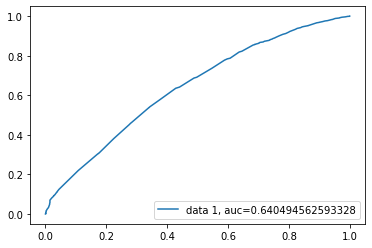

In [6]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

accuracy
0.7379802162410858
precision
0.9588014981273408
recall
0.0430976430976431
BER
0.47879938991050097


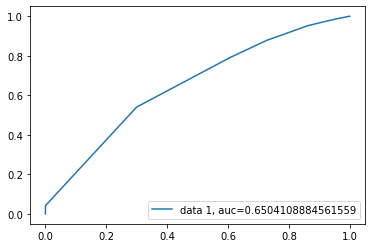

In [7]:
new_df = df.loc[:, df.columns.intersection(['distribution_channel','deposit_type','total_of_special_requests'])]
X = features_to_encode_and_bind(['distribution_channel','deposit_type'],new_df)
Y = df['is_canceled']

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

logreg = LogisticRegression(solver='lbfgs', max_iter=400)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

calc_accuracy(y_test, y_pred)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print(cnf_matrix)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correct predictions
# print("Precision:",metrics.precision_score(y_test, y_pred)) #if I say it was cancelled, how many were actually cancelled
# print("Recall:",metrics.recall_score(y_test, y_pred)) #if they actually cancelled, how many was caught

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


accuracy
0.7992178513917645
precision
0.6865530303030303
recall
0.4882154882154882
BER
0.29780425335980887


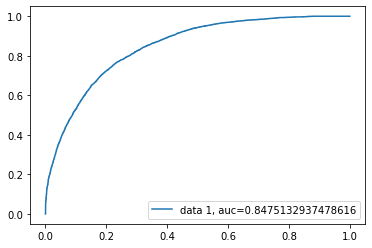

In [9]:
new_df = df.loc[:, df.columns.intersection(['offset','hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'agent_is_null',
       'company_is_null'])]
#print(new_df.isna().sum())
X = features_to_encode_and_bind(['hotel','arrival_date_year','arrival_date_month','arrival_date_week_number','meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type',],new_df)
Y = df['is_canceled']

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

calc_accuracy(y_test, y_pred)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print(cnf_matrix)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correct predictions
# print("Precision:",metrics.precision_score(y_test, y_pred)) #if I say it was cancelled, how many were actually cancelled
# print("Recall:",metrics.recall_score(y_test, y_pred)) #if they actually cancelled, how many was caught

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


# 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
#        'arrival_date_month', 'arrival_date_week_number',
#        'arrival_date_day_of_month', 'stays_in_weekend_nights',
#        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
#        'country', 'market_segment', 'distribution_channel',
#        'is_repeated_guest', 'previous_cancellations',
#        'previous_bookings_not_canceled', 'reserved_room_type',
#        'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
#        'company', 'days_in_waiting_list', 'customer_type', 'adr',
#        'required_car_parking_spaces', 'total_of_special_requests',
#        'reservation_status', 'reservation_status_date', 'agent_is_null',
#        'company_is_null'

In [21]:

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(method='bfgs',maxiter = 1000)
print(result.summary())

/Users/henryli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/henryli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/henryli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/henryli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.421109
         Iterations: 871
         Function evaluations: 881
         Gradient evaluations: 876


/Users/henryli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                65205
Model:                          Logit   Df Residuals:                    64975
Method:                           MLE   Df Model:                          229
Date:                Mon, 29 Nov 2021   Pseudo R-squ.:                  0.2861
Time:                        22:32:28   Log-Likelihood:                -27458.
converged:                       True   LL-Null:                       -38463.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
lead_time                          0.0070        nan        nan        nan         nan         nan
arrival_date_day_of_month          0.0008        nan        nan        

In [75]:
result_params = result.params
sorted_coeff = result_params.abs().sort_values()
last100 = sorted_coeff.iloc[-200:]
last100.to_csv("last150.csv")
#takeout: arrival_date_day_of_month, distribution_channel_Undefined, days_in_waiting_list, 
#lead_time, adr, stays_in_weekend_nights, stays_in_week_nights, babies, adults

accuracy
0.772716816195077
precision
0.6519756838905775
recall
0.3611111111111111
BER
0.3556900918012029


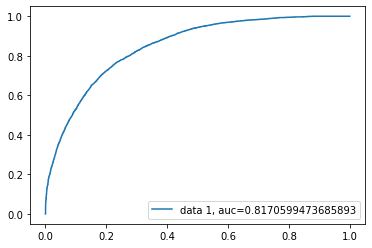

In [73]:
second_iteration_df = df.loc[:, df.columns.intersection(['offset',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests'
       ])]
#print(new_df.isna().sum())
X_second = features_to_encode_and_bind(['country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type',],second_iteration_df)
Y = df['is_canceled']

X_train2,X_test2,y_train2,y_test2 = train_test_split(X_second,Y,test_size=0.25,random_state=0)

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train2,y_train2)
y_pred2 = logreg.predict(X_test2)

calc_accuracy(y_test2, y_pred2)

cnf_matrix = metrics.confusion_matrix(y_test2, y_pred2)
# print(cnf_matrix)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correct predictions
# print("Precision:",metrics.precision_score(y_test, y_pred)) #if I say it was cancelled, how many were actually cancelled
# print("Recall:",metrics.recall_score(y_test, y_pred)) #if they actually cancelled, how many was caught

y_pred_proba2 = logreg.predict_proba(X_test2)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test2,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test2, y_pred_proba2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc2))
plt.legend(loc=4)
plt.show()

In [138]:
group_country_total =df.groupby(['country']).count()['is_canceled']
new_group_total = list(group_country_total[group_country_total < 3].index)
no_country_df = df[~df['country'].isin(new_group_total)]
removed_outliers = features_to_removed( [('children',10),('distribution_channel','Undefined'),('assigned_room_type','L'),('assigned_room_type','P'),('reserved_room_type','P')] , no_country_df)
removed_outliers['lead_time'] = round(np.log(removed_outliers['lead_time']))
removed_outliers = removed_outliers.replace([np.inf, -np.inf], 0)      
# print(removed_outliers[removed_outliers['lead_time'] == -np.inf]['lead_time'])
# # removed_outliers.replace([np.inf, -np.inf], 0)  

/Users/henryli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


accuracy
0.8073398719896855
precision
0.7084632516703786
recall
0.5252642007926024
BER
0.279159611499491


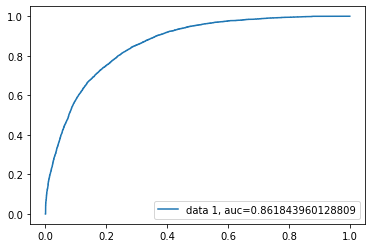

In [139]:
new_df = removed_outliers.loc[:, removed_outliers.columns.intersection(['offset','hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'agent_is_null',
       'company_is_null'])]

X = features_to_encode_and_bind(['hotel','arrival_date_year','arrival_date_month','arrival_date_week_number','meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type',],new_df)
Y = removed_outliers['is_canceled']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

calc_accuracy(y_test, y_pred)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print(cnf_matrix)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correct predictions
# print("Precision:",metrics.precision_score(y_test, y_pred)) #if I say it was cancelled, how many were actually cancelled
# print("Recall:",metrics.recall_score(y_test, y_pred)) #if they actually cancelled, how many was caught

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

accuracy
0.8070635907353686
precision
0.7076101468624834
recall
0.5250990752972259
BER
0.27940180645457335


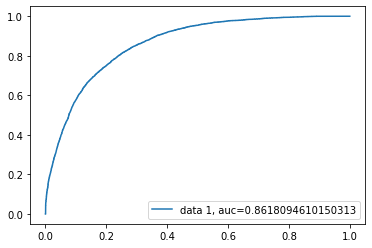

In [140]:
new_df = removed_outliers.loc[:, removed_outliers.columns.intersection(['offset','hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'agent_is_null',
       'company_is_null'])]
#print(new_df.isna().sum())
X = features_to_encode_and_bind(['hotel','arrival_date_month','meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type',],new_df)
Y = removed_outliers['is_canceled']

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

calc_accuracy(y_test, y_pred)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print(cnf_matrix)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correct predictions
# print("Precision:",metrics.precision_score(y_test, y_pred)) #if I say it was cancelled, how many were actually cancelled
# print("Recall:",metrics.recall_score(y_test, y_pred)) #if they actually cancelled, how many was caught

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
